# Statistics

> Scripts to generate statistics out of orbit data

In [ ]:
#| default_exp stats

In [ ]:
#| export
#| hide
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap.umap_ as umap
from typing import List, Any, Dict, Optional

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-07 11:28:42.100128: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
#| hide
from fastcore.test import test_eq

In [ ]:
#| test
from orbit_generation.data import get_example_orbit_data

In [ ]:
#| test
orbit_data = get_example_orbit_data()
orbit_data.shape

(200, 6, 300)

## Simple statistics

In [ ]:
#| export
def calculate_overall_statistics(orbits: np.ndarray  # The array containing orbit data of shape (number_of_orbits, 6, number_of_time_instants).
                                 ) -> Dict[str, Dict[str, float]]:
    """
    Calculate the overall min, mean, max, and percentile statistics for each scalar 
    (position and velocity in X, Y, Z) across all time instants and orbits.

    Parameters:
    - orbits (np.ndarray): A numpy array of shape (number_of_orbits, 6, number_of_time_instants) containing orbit data.

    Returns:
    - Dict[str, Dict[str, float]]: A dictionary with statistics ('min', 'mean', 'max', '25%', '50%', '75%') for each scalar.
    """
    stats = {}  # Dictionary to store statistics for each scalar.
    scalar_names = ['posx', 'posy', 'posz', 'velx', 'vely', 'velz']  # List of scalar names for positions and velocities.
    
    for scalar_index, scalar_name in enumerate(scalar_names):
        scalar_data = orbits[:, scalar_index, :].flatten()  # Flatten data to combine all orbits and time points for each scalar.
        
        # Calculate statistics for the current scalar and store them in the dictionary.
        stats[scalar_name] = {
            'min': np.min(scalar_data),  # Minimum value.
            'mean': np.mean(scalar_data),  # Mean value.
            'max': np.max(scalar_data),  # Maximum value.
            '25%': np.percentile(scalar_data, 25),  # 25th percentile.
            '50%': np.median(scalar_data),  # Median, equivalent to the 50th percentile.
            '75%': np.percentile(scalar_data, 75)  # 75th percentile.
        }
    
    return stats  # Return the dictionary containing all calculated statistics.

In [ ]:
#| test "basic functionality"
orbits = np.array([
    [[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]],  # Orbit 1
    [[4, 4, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9]]   # Orbit 2
])

# Call the function to calculate statistics
stats = calculate_overall_statistics(orbits)

# Using test_eq to perform tests
test_eq(stats['posx']['min'], 1)
test_eq(stats['posx']['mean'], 3)
test_eq(stats['posx']['max'], 4)
test_eq(stats['posx']['25%'], 2.25)
test_eq(stats['posx']['50%'], 3.5)
test_eq(stats['posx']['75%'], 4)

## Plot Time

In [ ]:
#| export
def plot_time_increments(orbit_dataset: np.ndarray,  # The 3D numpy array representing the orbits
                         orbits_to_plot: List[int] = None,  # Optional list of integers referring to the orbits to plot
                         show_legend: bool = True  # Boolean to control the display of the legend
                        ) -> None:
    """
    Plots the time as a function to visualize how it increments for each orbit.

    Parameters:
    orbit_dataset (np.ndarray): A 3D numpy array where the first dimension is the number of orbits,
                                the second dimension contains 7 scalars (time, posx, posy, posz, velx, vely, velz),
                                and the third dimension is the time steps.
    orbits_to_plot (list[int], optional): List of integers referring to the orbits to plot. If None, plots all orbits.
    show_legend (bool, optional): Whether to display the legend. Default is True.
    """
    num_orbits = orbit_dataset.shape[0]

    # If orbits_to_plot is not provided, plot all orbits
    if orbits_to_plot is None:
        orbits_to_plot = list(range(num_orbits))

    plt.figure(figsize=(10, 6))

    for i in orbits_to_plot:
        time_steps = orbit_dataset[i, 0]  # Extract the time steps for the current orbit
        plt.plot(time_steps, label=f'Orbit {i}')

    plt.xlabel('Time Step Index')
    plt.ylabel('Time')
    plt.title('Time Increments for Orbits')
    
    if show_legend:
        plt.legend()
    
    plt.grid(True)
    plt.show()

## Plot Histograms

In [ ]:
#| export
def plot_orbit_data_lengths(orbit_data, key_range=(1, 36072), dimension=0, bins=30, color='blue', plot=True, title='Histogram of Orbits Time Steps'):
    lengths = []
    
    # Iterate over each dataset name within the provided range
    start, end = key_range  # Unpack the tuple for range
    for key in range(start, end):
        if key in orbit_data:
            try:
                # Append the length of the specified dimension of the dataset
                lengths.append(len(orbit_data[key][dimension]))
            except IndexError:
                # Handle the case where the dimension is not available
                print(f"Warning: Dimension {dimension} is not available in dataset {key}.")
                continue
    
    if plot:
        # Plot the histogram of these lengths if plot is True
        plt.figure(figsize=(10, 6))
        plt.hist(lengths, bins=bins, color=color, edgecolor='black')
        plt.title(title)
        plt.xlabel('Time Steps')
        plt.ylabel('Frequency')
        plt.show()
    else:
        # Return lengths data for further analysis
        return lengths

In [ ]:
#| export
def plot_histograms_position(data: np.ndarray,  # The orbit data array of shape (num_orbits, num_scalars, num_time_points).
                             save_path: str = None  # Optional path to save the plot image.
                            ) -> None:
    """
    Plots histograms for the scalar values (position and velocity in X, Y, Z, and optionally time) across all orbits
    and time points. Handles arrays with 6 or 7 scalar dimensions, with the 7th being 'time'.

    Parameters:
    - data (np.ndarray): The orbit data array.
    - save_path (str, optional): If provided, the plot will be saved to this file path.
    """
    # Check the number of scalars and adjust scalar names accordingly
    num_scalars = data.shape[1]
    if num_scalars == 7:
        scalar_names = ['time', 'posX', 'posY', 'posZ', 'velX', 'velY', 'velZ']
    elif num_scalars == 6:
        scalar_names = ['posX', 'posY', 'posZ', 'velX', 'velY', 'velZ']
    else:
        raise ValueError("Data arrays must have either 6 or 7 scalar dimensions.")

    # Setting up the subplot grid, dynamically adjusting if we have 7 scalars
    rows, cols = (3, 3) if num_scalars == 7 else (2, 3)
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust height based on rows
    fig.suptitle('Histograms of Position, Velocity Components, and Time (if present) Across All Orbits')
    
    for i in range(num_scalars):
        scalar_values = data[:, i, :].flatten()  # Flatten combines all orbits and time points for each scalar
        
        row, col = divmod(i, cols)  # Determine subplot position
        axs[row, col].hist(scalar_values, bins=50, alpha=0.75)  # You can adjust the number of bins
        axs[row, col].set_title(f'{scalar_names[i]}')
        axs[row, col].set_ylabel('Frequency')
        axs[row, col].set_xlabel('Value')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
    
    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path)  # Save the figure to the specified path

    # Display the figure regardless of saving
    plt.show()

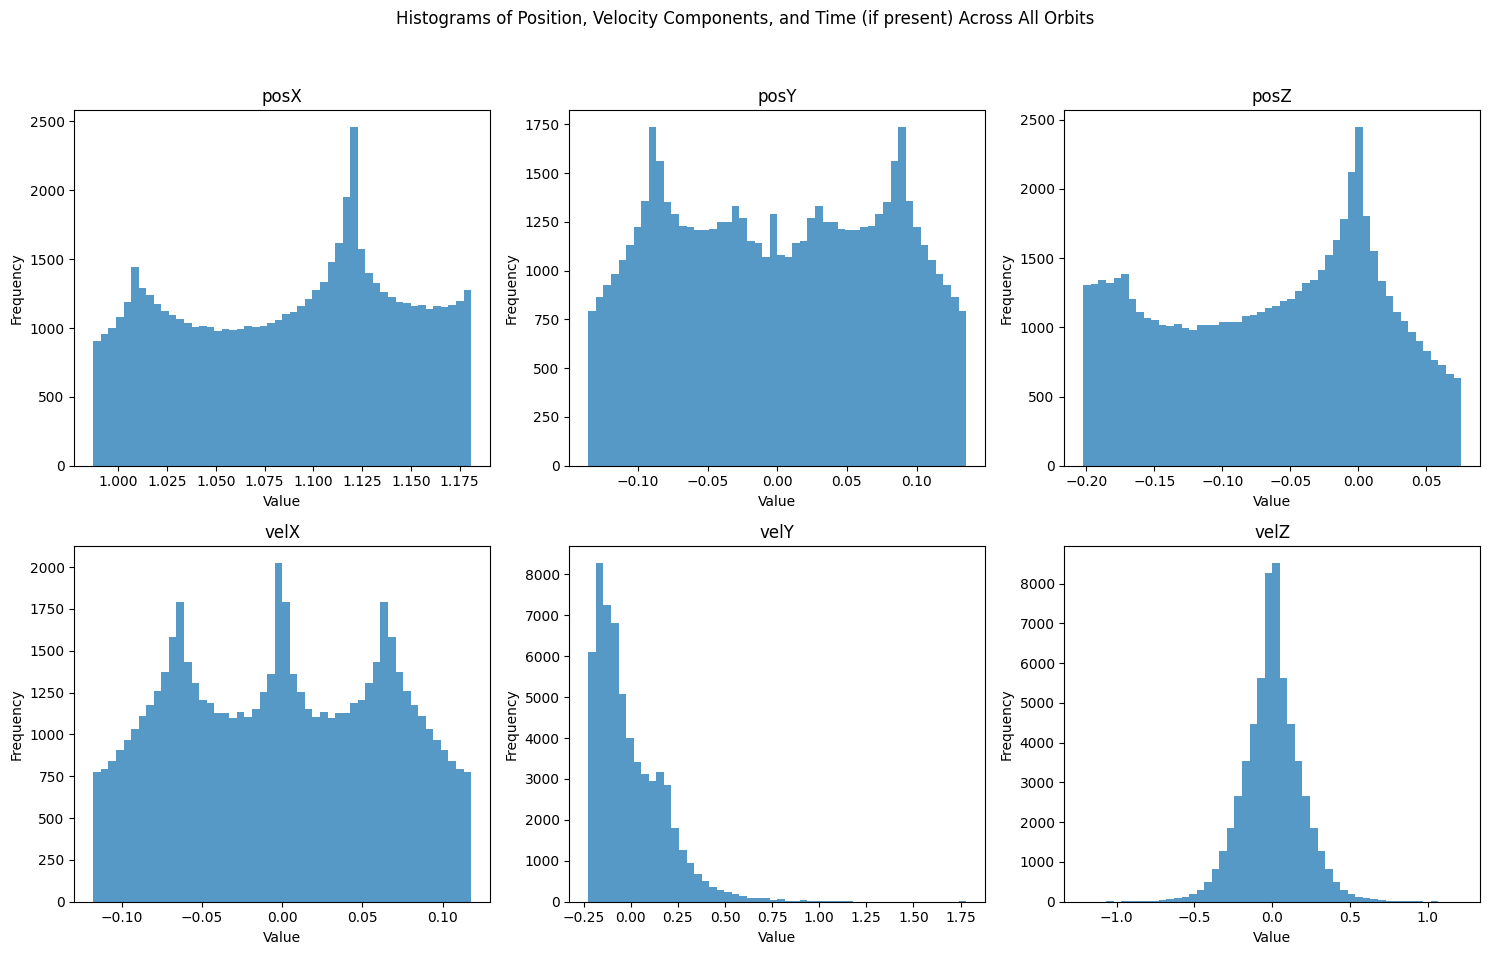

In [ ]:
#| test plot_histograms_position
plot_histograms_position(orbit_data)

In [ ]:
#| export
def plot_histograms_comparison(data1: np.ndarray,  # First orbit data array of shape (num_orbits, num_scalars, num_time_points).
                               data2: np.ndarray,  # Second orbit data array of shape (num_orbits, num_scalars, num_time_points).
                               label1: str = "Dataset 1",  # Label for the first dataset.
                               label2: str = "Dataset 2",  # Label for the second dataset.
                               save_path: str = None,  # Optional path to save the plot image.
                               normalize: bool = False  # Normalize histograms to show relative frequencies.
                               ) -> None:
    """
    Plots histograms for scalar values (position, velocity in X, Y, Z, and optionally time) from two datasets on 
    the same chart with different colors. Supports both 6 and 7 scalar dimensions, with the 7th being 'time'.
    Optionally saves the plot to a specified file path and can normalize histograms for relative comparison.
    """
    # Check the number of scalars and adjust scalar names accordingly
    num_scalars = data1.shape[1]
    scalar_names = ['posX', 'posY', 'posZ', 'velX', 'velY', 'velZ']
    if num_scalars == 7:
        scalar_names.insert(0, 'time')

    if num_scalars not in [6, 7]:
        raise ValueError("Data arrays must have either 6 or 7 scalar dimensions.")

    # Setting up the subplot grid
    rows, cols = (3, 3) if num_scalars == 7 else (2, 3)
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    fig.suptitle('Comparative Histograms of Position, Velocity Components, and Time (if present)')

    # Plot histograms
    for i in range(num_scalars):
        scalar_values1 = data1[:, i, :].flatten()
        scalar_values2 = data2[:, i, :].flatten()
        row, col = divmod(i, 3)
        
        density = normalize  # Use the same variable for clarity in the hist function call
        axs[row, col].hist(scalar_values1, bins=50, alpha=0.75, color='blue', label=label1, density=density)
        axs[row, col].hist(scalar_values2, bins=50, alpha=0.75, color='green', label=label2, density=density)
        
        axs[row, col].set_title(scalar_names[i])
        axs[row, col].set_ylabel('Density' if normalize else 'Frequency')
        axs[row, col].set_xlabel('Value')
        axs[row, col].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Saving or showing the plot
    if save_path:
        plt.savefig(save_path)
    plt.show()

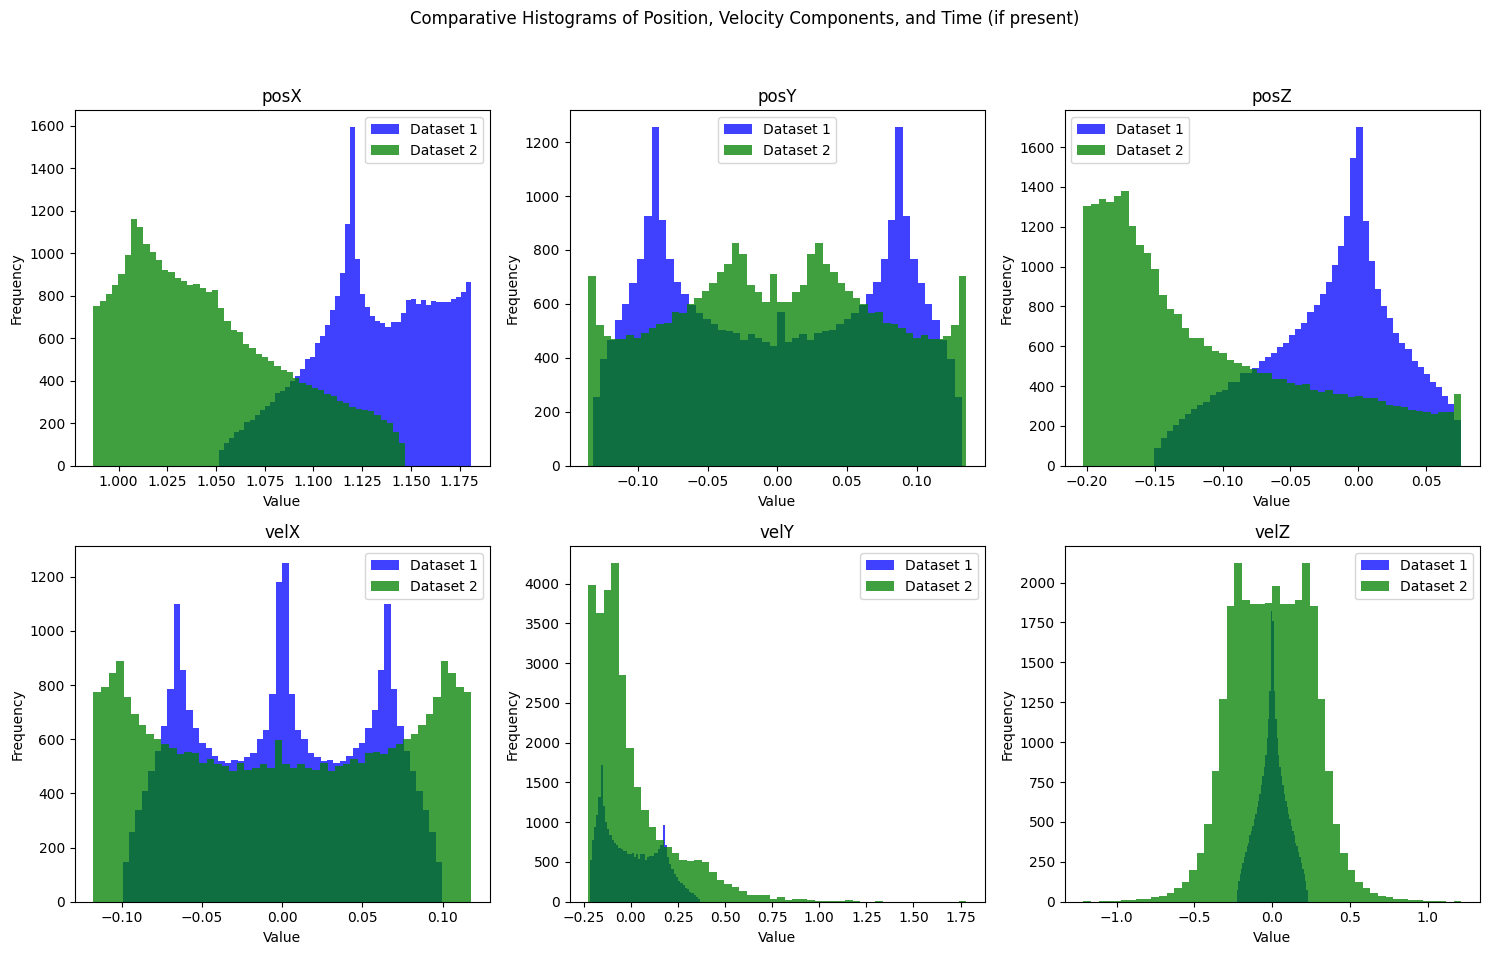

In [ ]:
#| test plot_histograms_comparison
orbit_data1 = orbit_data[:100]
orbit_data2 = orbit_data[100:]

plot_histograms_comparison(orbit_data1, orbit_data2)

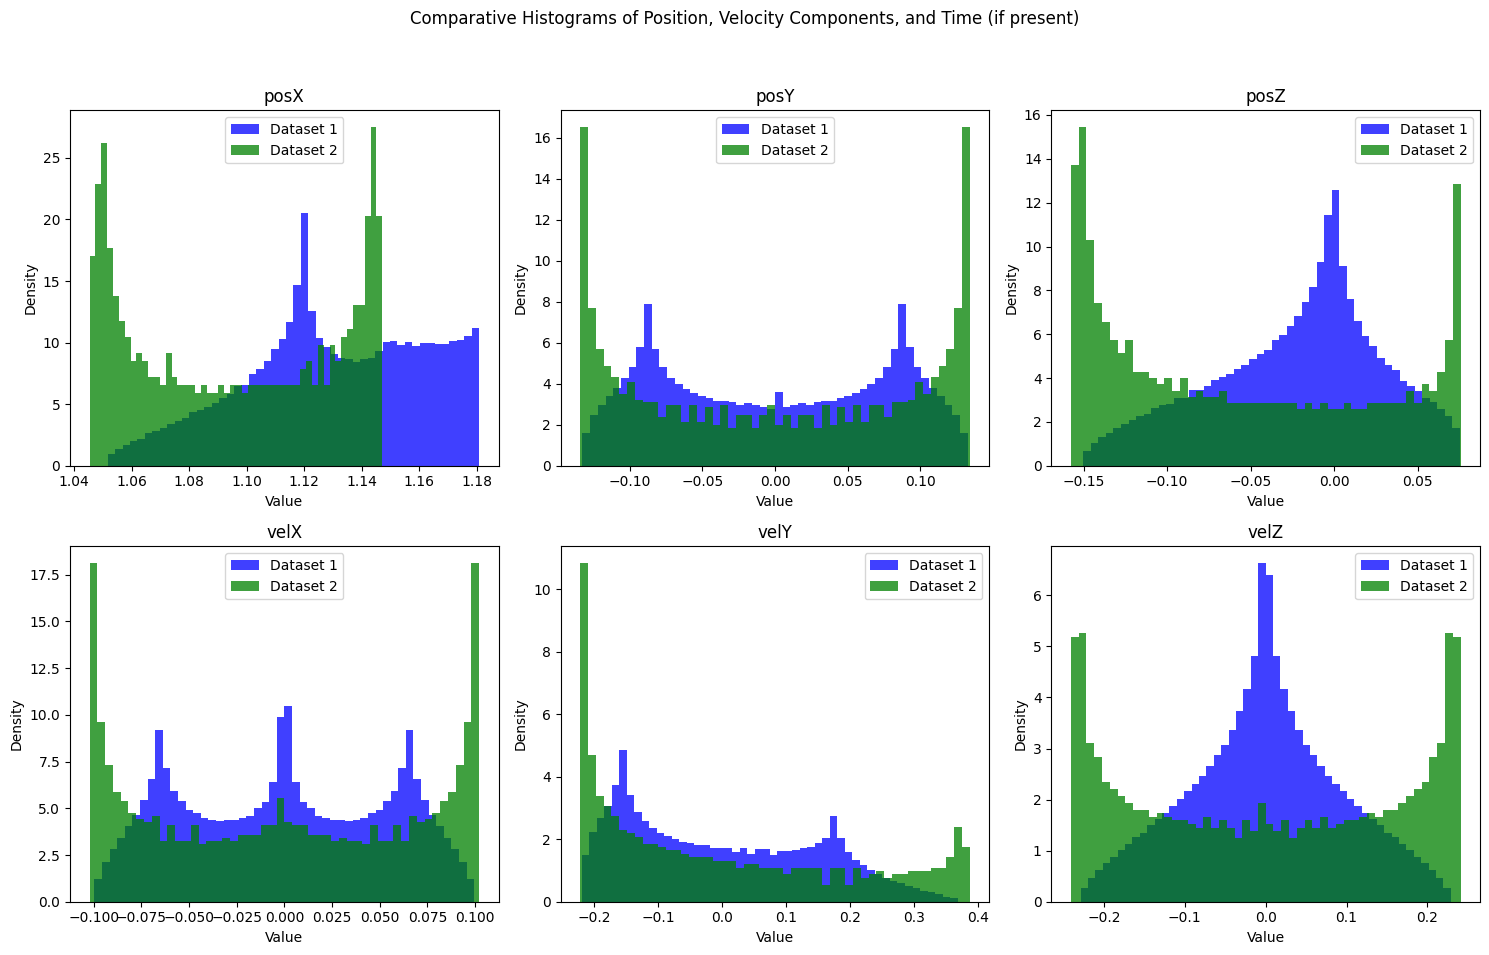

In [ ]:
orbit_data3 = orbit_data2[:5]

plot_histograms_comparison(orbit_data1, orbit_data3, normalize=True)

## Latent Space

In [ ]:
#| export
def plot_latent_space(
        latent_representations: np.ndarray,  # Precomputed latent representations (numpy array).
        labels: np.ndarray,                  # Labels for the data points, used for coloring in the plot.
        techniques: List[str] = ['PCA'],     # Techniques to use for reduction ('PCA', 't-SNE', 'UMAP', 'LDA').
        n_components: int = 2,               # Number of dimensions to reduce to (1, 2, or 3).
        figsize: tuple = (12, 9),            # Size of the figure for each subplot.
        colors: Optional[List[str]] = None,  # Optional list of colors for the labels. If None, use random colors.
        save_path: Optional[str] = None,     # Optional path to save the plot image.
        **kwargs: Any                        # Additional keyword arguments for dimensionality reduction methods.
    ) -> None:
    """
    Plots and optionally saves the latent space representations using specified dimensionality reduction techniques.
    Each technique's plot is handled in a separate figure, supporting 1D, 2D, or 3D visualizations.
    """
    models = {
        'PCA': PCA(n_components=n_components),
        't-SNE': TSNE(n_components=n_components, **kwargs),
        'UMAP': umap.UMAP(n_components=n_components, **kwargs),
        'LDA': LinearDiscriminantAnalysis(n_components=n_components)
    }

    for technique in techniques:
        model = models.get(technique)
        if not model:
            continue  # Skip if model not found in dictionary

        if technique == 'LDA':
            results = model.fit_transform(latent_representations, labels)
        else:
            results = model.fit_transform(latent_representations)

        if n_components == 1:
            fig, ax = plt.subplots(figsize=figsize)
            scatter = ax.scatter(results, np.zeros_like(results), c=labels, cmap='viridis' if colors is None else colors, s=30)
            ax.set_xlabel(f'{technique} Component 1')
        elif n_components == 2:
            fig, ax = plt.subplots(figsize=figsize)
            scatter = ax.scatter(results[:, 0], results[:, 1], c=labels, cmap='viridis' if colors is None else colors, s=30)
            ax.set_xlabel(f'{technique} Dimension 1')
            ax.set_ylabel(f'{technique} Dimension 2')
        elif n_components == 3:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(results[:, 0], results[:, 1], results[:, 2], c=labels, cmap='viridis' if colors is None else colors, s=30)
            ax.set_xlabel(f'{technique} Dimension 1')
            ax.set_ylabel(f'{technique} Dimension 2')
            ax.set_zlabel(f'{technique} Dimension 3')

        ax.set_title(f'Visualization with {technique}')
        plt.colorbar(scatter, ax=ax, label='Class')
        if save_path:
            individual_save_path = f"{save_path}_{technique}.png"
            plt.savefig(individual_save_path)
            print(f"Saved plot to {individual_save_path}")
        plt.show()

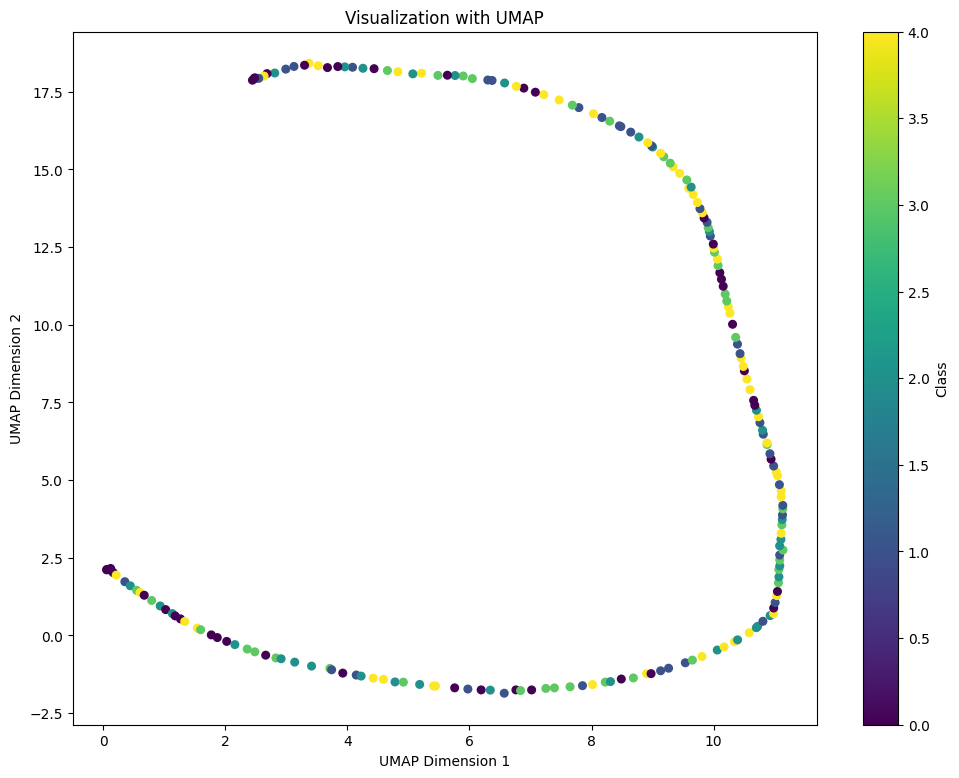

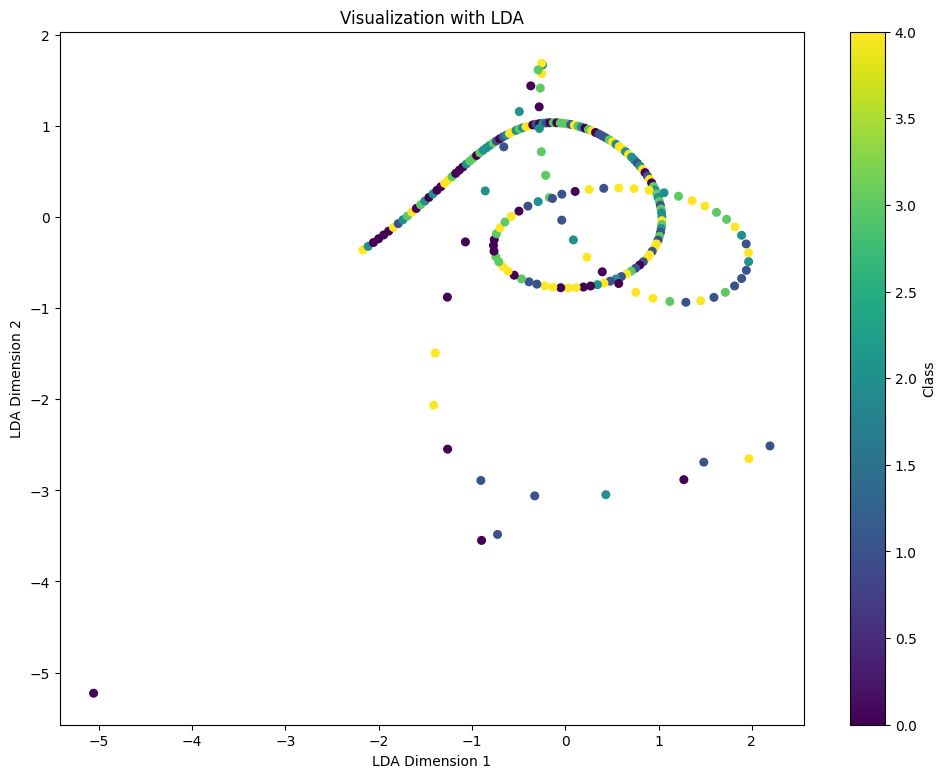

In [ ]:
#| test plot_latent_space

# Reshape data to 2D (num_orbits, 6 * num_time_points)
orbit_data_reshaped = orbit_data.reshape(200, -1)

# Use PCA to reduce to a lower-dimensional space (e.g., 10 dimensions)
pca = PCA(n_components=10)
latent_representations = pca.fit_transform(orbit_data_reshaped)

labels = np.random.randint(0, 5, size=200)  # 5 different classes

plot_latent_space(latent_representations, labels, techniques=['UMAP','LDA'])

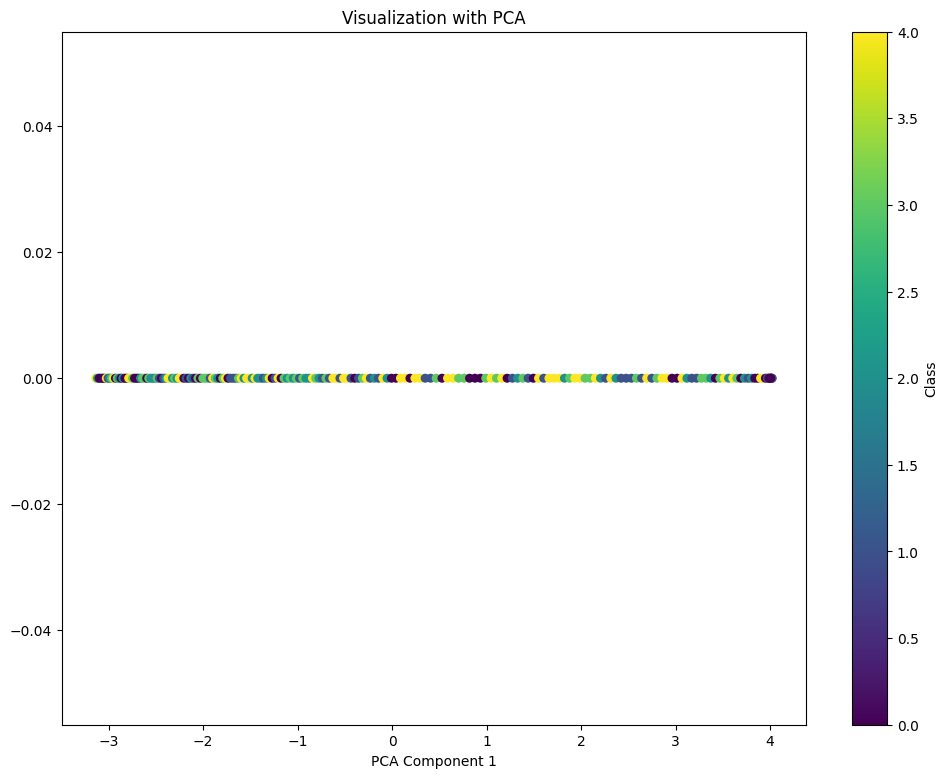

In [ ]:
#| test plot_latent_space
plot_latent_space(latent_representations, labels, techniques=['PCA'], n_components=1)

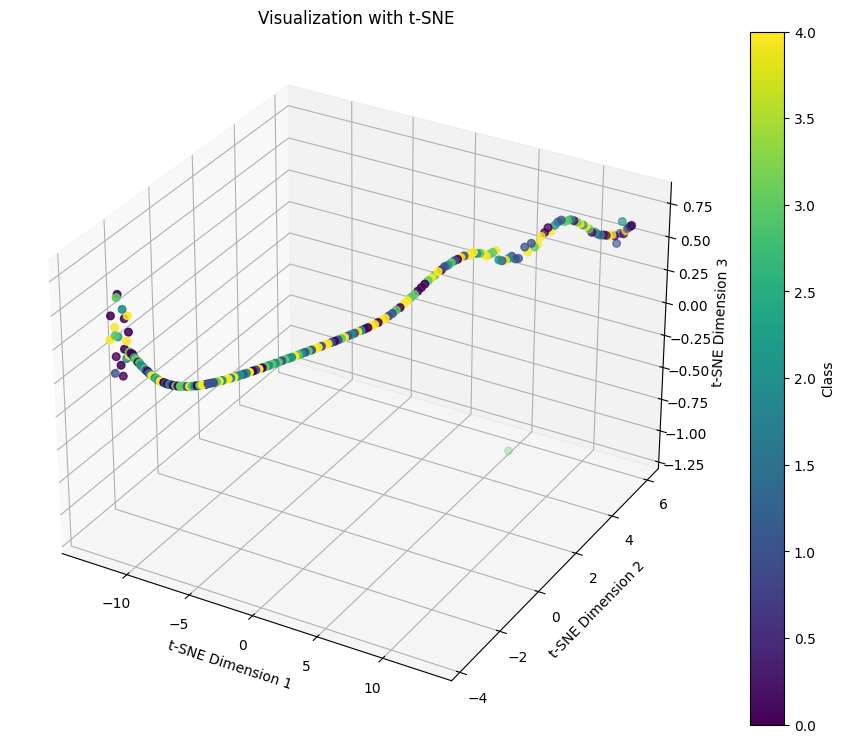

In [ ]:
#| test plot_latent_space
plot_latent_space(latent_representations, labels, techniques=['t-SNE'], n_components=3)

## Latent Space Synthetic vs Real

In [ ]:
# | export
def plot_combined_latent_space(
        real_data: np.ndarray,                # Real data samples.
        synthetic_data: np.ndarray,           # Synthetic data samples generated by a model.
        encoder,                              # Encoder function or model that predicts latent space representations.
        techniques: List[str] = ['PCA'],      # Techniques to use for reduction ('PCA', 't-SNE', 'UMAP', 'LDA').
        n_components: int = 2,                # Number of dimensions to reduce to.
        figsize: tuple = (12, 9),             # Size of the figure for each subplot.
        colors: Optional[List[str]] = None,   # Optional list of colors for the labels. If None, use random colors.
        save_path: Optional[str] = None,      # Optional path to save the plot image.
        **kwargs: Any                         # Additional keyword arguments for dimensionality reduction methods.
    ) -> None:
    """
    Plots the combined latent space of real and synthetic data using specified dimensionality reduction techniques.
    """
    # Concatenate real and synthetic data
    combined_data = np.concatenate([real_data, synthetic_data], axis=0)

    # Create labels for real and synthetic data
    real_labels = np.zeros(real_data.shape[0], dtype=int)
    synthetic_labels = np.ones(synthetic_data.shape[0], dtype=int)
    combined_labels = np.concatenate([real_labels, synthetic_labels], axis=0)

    # Generate latent representations for the combined dataset
    latent_outputs = encoder.predict(combined_data)
    latent_representations = latent_outputs[0]  # Assuming the mean of the latent space is the first output

    # Plot the latent space using the previously defined function
    plot_latent_space(
        latent_representations=latent_representations,
        labels=combined_labels,
        techniques=techniques,
        n_components=n_components,
        figsize=figsize,
        colors=colors,
        save_path=save_path,
        **kwargs
    )


In [ ]:
# | export
def plot_combined_latent_space_with_labels(
        real_data: np.ndarray,                # Real data samples.
        synthetic_data: np.ndarray,           # Synthetic data samples generated by a model.
        real_labels: np.ndarray,              # Labels for the real data samples.
        encoder,                              # Encoder function or model that predicts latent space representations.
        techniques: List[str] = ['PCA'],      # Techniques to use for reduction ('PCA', 't-SNE', 'UMAP', 'LDA').
        n_components: int = 2,                # Number of dimensions to reduce to.
        figsize: tuple = (12, 9),             # Size of the figure for each subplot.
        real_colors: Optional[List[str]] = None,   # Optional list of colors for the real data labels. If None, use random colors.
        synthetic_color: str = 'red',         # Color for the synthetic data points.
        save_path: Optional[str] = None,      # Optional path to save the plot image.
        **kwargs: Any                         # Additional keyword arguments for dimensionality reduction methods.
    ) -> None:
    """
    Plots the combined latent space of real and synthetic data using specified dimensionality reduction techniques.
    The real data points are colored according to their labels, and the synthetic data points are overlaid in a new color.
    """
    # Concatenate real and synthetic data
    combined_data = np.concatenate([real_data, synthetic_data], axis=0)

    # Create labels for real and synthetic data
    synthetic_labels = np.full(synthetic_data.shape[0], -1, dtype=int)  # Use -1 to distinguish synthetic data
    combined_labels = np.concatenate([real_labels, synthetic_labels], axis=0)

    # Generate latent representations for the combined dataset
    latent_outputs = encoder.predict(combined_data)
    latent_representations = latent_outputs[0]  # Assuming the mean of the latent space is the first output

    models = {
        'PCA': PCA(n_components=n_components),
        't-SNE': TSNE(n_components=n_components, **kwargs),
        'UMAP': umap.UMAP(n_components=n_components, **kwargs),
        'LDA': LinearDiscriminantAnalysis(n_components=n_components)
    }

    for technique in techniques:
        model = models.get(technique)
        if not model:
            continue  # Skip if model not found in dictionary

        if technique == 'LDA':
            results = model.fit_transform(latent_representations, combined_labels)
        else:
            results = model.fit_transform(latent_representations)

        fig = plt.figure(figsize=figsize)
        if n_components == 1:
            ax = fig.add_subplot(111)
            real_data_points = ax.scatter(results[:real_data.shape[0]], np.zeros(real_data.shape[0]), c=real_labels, cmap='viridis' if real_colors is None else real_colors, s=30, label='Real Data')
            synthetic_data_points = ax.scatter(results[real_data.shape[0]:], np.zeros(synthetic_data.shape[0]), c=synthetic_color, s=30, label='Synthetic Data')
            ax.set_xlabel(f'{technique} Component 1')
        elif n_components == 2:
            ax = fig.add_subplot(111)
            real_data_points = ax.scatter(results[:real_data.shape[0], 0], results[:real_data.shape[0], 1], c=real_labels, cmap='viridis' if real_colors is None else real_colors, s=30, label='Real Data')
            synthetic_data_points = ax.scatter(results[real_data.shape[0]:, 0], results[real_data.shape[0]:, 1], c=synthetic_color, s=30, label='Synthetic Data')
            ax.set_xlabel(f'{technique} Dimension 1')
            ax.set_ylabel(f'{technique} Dimension 2')
        elif n_components == 3:
            ax = fig.add_subplot(111, projection='3d')
            real_data_points = ax.scatter(results[:real_data.shape[0], 0], results[:real_data.shape[0], 1], results[:real_data.shape[0], 2], c=real_labels, cmap='viridis' if real_colors is None else real_colors, s=30, label='Real Data')
            synthetic_data_points = ax.scatter(results[real_data.shape[0]:, 0], results[real_data.shape[0]:, 1], results[real_data.shape[0]:, 2], c=synthetic_color, s=30, label='Synthetic Data')
            ax.set_xlabel(f'{technique} Dimension 1')
            ax.set_ylabel(f'{technique} Dimension 2')
            ax.set_zlabel(f'{technique} Dimension 3')

        ax.set_title(f'Visualization with {technique}')
        plt.legend()
        if save_path:
            individual_save_path = f"{save_path}_{technique}.png"
            plt.savefig(individual_save_path)
            print(f"Saved plot to {individual_save_path}")
        plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()